# Identifying ghost hotels

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from pysal.lib import weights

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances_chunked
from sklearn.cluster import DBSCAN
from numbers import Number
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [2]:
norm_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings-with-nlp-subset.csv.gz?raw=true',
                compression='gzip', dtype={'id':np.float64, 'listing_url':str, 'name':str, 'description':str, 'description_norm':str})
ref_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true',
                    compression='gzip', usecols=['id', 'room_type', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'host_id', 'host_name', 'availability_365', 'latitude', 'longitude', 'price', 'number_of_reviews_ltm', 'minimum_nights'],
                    dtype={'id':np.float64,
                           'room_type':str, 
                           'calculated_host_listings_count':np.float64,
                           'calculated_host_listings_count_entire_homes':np.float64,
                           'host_id':np.float64, 
                           'host_name':str, 
                           'availability_365':np.float64,
                           'latitude':np.float64,
                          'longitude':np.float64,
                          'price':str,
                          'number_of_reviews_ltm':np.float64,
                          'minimum_nights':np.float64})

In [24]:
df = pd.merge(norm_df, ref_df, on='id') #default is inner so we leave it
problematic_listings = df[(df.room_type == 'Hotel room') |
           (df.id.isna()) |
           (df.calculated_host_listings_count.isna()) |
           (df.latitude.isna())]
print(f'{(problematic_listings.shape[0]/df.shape[0])*100:.2f}% of listings cannot be used in the analysis, and will be dropped')
df.drop(problematic_listings.index, inplace=True)

#Converting columns
df['price'] = df['price'].str.replace('$','').str.replace(',','').astype('float')
ints = ['id', 'host_id', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'availability_365', 'number_of_reviews_ltm', 'minimum_nights']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype(pd.UInt16Dtype())

#Setting custom index
df.set_index('id', inplace=True)

0.78% of listings cannot be used in the analysis, and will be dropped
Converting id
Converting host_id
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting availability_365
Converting number_of_reviews_ltm
Converting minimum_nights


<AxesSubplot:ylabel='Frequency'>

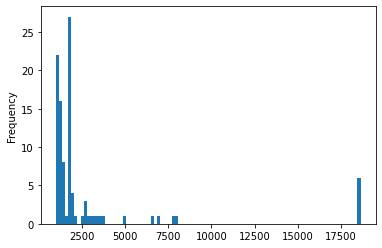

In [13]:
#Find values of abnormally priced listings
pd.Series(sorted(df['price'].values, reverse=True)[:100]).plot.hist(bins=100) #some listings have abnormally high values

In [25]:
#Dropping listings with abnormally high prices
abnormal_prices = df[df['price'] > 10000]
print(f'{(abnormal_prices.shape[0]/df.shape[0])*100:.2f}% of listings had abnormally high prices that may skew the revenue analysis, and will be dropped')
df.drop(abnormal_prices.index, inplace=True)

0.01% of listings had abnormally high prices that may skew the revenue analysis, and will be dropped


In [26]:
#Finding revenue from revenue-generating listings
def get_revenue(minimum_nights:int, number_of_reviews_ltm:int, price:float) -> float:
    s = 5.3 #average stay in London, based on GLA report
    if minimum_nights > s: #hosts can set a minimum nights stay of longer than 5.3 nights
        s = minimum_nights
    b = 2 * number_of_reviews_ltm #assumes that 50% of bookings result in reviews, based on Inside Airbnb model
    occupancy = s*b #estimates number of nights property was occupied
    if occupancy > 255: #building on GLA report, occupancy is capped at 255 nights
        occupancy = 255
    p = price 
    rev = occupancy * p #revenue is multiplied by the nightly price and number of nights occupied
    return rev

df['revenue'] = df.apply(lambda x: get_revenue(x.minimum_nights, x.number_of_reviews_ltm, x.price), axis=1)

In [27]:
#Dropping non-revenue generating listings and listings with abnormal prices, which indicate lack of availability or typos
non_revenue = df[df['revenue'] == 0]

print(f'{(non_revenue.shape[0]/df.shape[0])*100:.2f}% of listings did not generate revenue in the past year, and will be dropped')

df.drop(non_revenue.index, inplace=True)
print(f'{df.shape[0]} listings will be used in the analysis')

54.38% of listings did not generate revenue in the past year, and will be dropped
33578 listings will be used in the analysis


## Ghost hotel extraction

In [31]:
def ghost_hotels(df):
    '''This function isolates potential ghost listings and performs textual + spatial cluster analysis.
    Use the original listings df as the input, and assign the output of this function to a new df'''
    potential_ghosts = df[(df['calculated_host_listings_count_entire_homes'] >= 2) &
                   (df['room_type'] == 'Entire home/apt') &
                   (~df['description_norm'].isna())].copy()
    print(f'There are {potential_ghosts.shape[0]} candidates for ghost listings, which make up {(potential_ghosts.shape[0]/df.shape[0])*100:.2f}% of revenue-generating listings in London.')
    
    print('Running textual similarity analysis...')
    corpus = potential_ghosts.description_norm.values
    vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), max_df=0.5, min_df=0.05)
    #ignore terms that appear in over 50% or less than 5% of documents to save memory
    tcorpus = vectorizer.fit_transform(corpus).toarray() 
    #fit creates list of words/ngrams + IDF scores
    #transform creates matrix of TF/IDF scores per word/ngram
    #convert to array for cosine similarity step
    
    #Cosine distance analysis
    keys = potential_ghosts.index #allows cosine distance calculator output to be indexed by listing ID, which makes analysis easier
    cosine_distances = pd.DataFrame(squareform(pdist(tcorpus, metric='cosine')), index=keys, columns=keys)
    
    #Filtering down to listings that meet criteria for textual similarity with multiple listings
    ghost_listings = cosine_distances[(cosine_distances < 0.2).sum(1) > 2].index.tolist()
    ghost_listings_mat = cosine_distances.loc[ghost_listings, ghost_listings]
    print(f'{ghost_listings_mat.shape[0]} listings had more than 1 textually similar listing, and will be used in the text clustering process.')
    
    #Set up data frame to store clustering results, which has all the columns in the original df
    results = potential_ghosts.loc[ghost_listings,]
    
    #Function for implementing both textual and spatial cluster analysis
    def db_cluster(df1, df2, eps:Number, metric:str, name:str):
        '''Implements DBSCAN clustering algorithm on df1 and stores results in df2'''
        print(f'Running {name} analysis...')
        output = DBSCAN(eps=eps, min_samples=3, metric=metric).fit(df1)
        s = pd.Series(output.labels_, index=df2.index, name=name) #create series assigning listings to clusters
        df2[name] = s #assign series to results df
        print(s.value_counts()) #visualise number of listings per cluster
        
        noise = df2[df2[name] == -1] #identify listings that weren't in clusters
        print(f'Dropping {noise.shape[0]} listings that do not belong to a cluster')
        df2.drop(noise.index, inplace=True)
        return df2 #returns filtered df, with only listings that are in clusters
    
    #Textual DBSCAN
    results = db_cluster(ghost_listings_mat, results, 0.2, 'precomputed', 'text_dbscan')
    
    #Spatial DBSCAN
    spatial_dbs_listings = results[['latitude', 'longitude']] #isolate latitude/longitude pairs
    spatial_dbs_listings = spatial_dbs_listings.apply(np.radians) #convert coordinates to radians for use in DBSCAN clustering
    
    e = 0.3/6371.0088 #divide maximum distance (in km) between two listings that could be in the same building by km per radian
    results = db_cluster(spatial_dbs_listings, results, e, 'haversine', 'geo_dbscan')
    
    #Identify potential hotels by grouping results df by combination of clusters
    #We assume that potential hotels are in the same spatial and textual clusters
    hotels = results.groupby(['geo_dbscan','text_dbscan']).size().reset_index().rename(columns={0:'count'})
    print(f'There are {hotels.shape[0]} potential ghost hotels in London.')
    
    #Match hotels to listings
    hotels['hotel_id'] = hotels.index.values   
    results['id'] = results.index.values #the merge can reset the index, which we don't want
    final_results = results.merge(hotels, how='left').set_index('id')
    print(f'{final_results.shape[0]} listings are in potential ghost hotels, which account for {(final_results.shape[0]/df.shape[0])*100:.2f}% of revenue-generating listings')
    
    #Free up memory so this function can be run on other listing datasets
    del(tcorpus)
    del(cosine_distances)
    
    return final_results

In [32]:
ghost_hotels_20 = ghost_hotels(df)

There are 9419 candidates for ghost listings, which make up 28.05% of revenue-generating listings in London.
Running textual similarity analysis...
2687 listings had more than 1 textually similar listing, and will be used in the text clustering process.
Running text_dbscan analysis...
 139    147
 202    107
 148     50
 293     42
-1       36
       ... 
 15       3
 11       3
 7        3
 5        3
 0        3
Name: text_dbscan, Length: 414, dtype: int64
Dropping 36 listings that do not belong to a cluster
Running geo_dbscan analysis...
 1      652
 8      289
 10     196
 11     164
-1       98
       ... 
 86       3
 84       3
 72       3
 70       3
 128      3
Name: geo_dbscan, Length: 130, dtype: int64
Dropping 98 listings that do not belong to a cluster
There are 496 potential ghost hotels in London.
2553 listings are in potential ghost hotels, which account for 7.603193% of revenue-generating listings


Before the analysis, we have to exclude listings from Sonder, a serviced apartment company that is licensed to run as a hotel. This clustering analysis identified Sonder's listings as potential ghost hotels. 

In [78]:
ghost_hotels_20.drop(ghost_hotels_20[
    ghost_hotels_20['host_name'].str.contains('Sonder')
].index, inplace=True)

print(f'{ghost_hotels_20.shape[0]} listings are in suspected ghost hotels.')

2406 listings are in suspected ghost hotels.


## Revenue analysis

### How much of the total revenue from Airbnb in London was generated by ghost hotels between 2019 and 2020?

In [ ]:
def revenue_analysis(df1, df2):
    '''This function analyses ghost-hotel listings' share of listings and revenue compared to entire-home listings
    and Airbnb listings in total.
    df1 is the full df of revenue-generating listings, and df2 is the df of suspected ghost-hotel listings.'''
    
    df1['is_ghost_listing'] = df1.index.isin(df2.index.values) #produce boolean series indicating whether or not a listing is a ghost-hotel listing
    entire_homes = df1[df1['room_type'] == 'Entire home/apt'] #isolate entire home listings
    
    def get_stat_table(df, name):
        '''This helper function produces the table used for the revenue analysis.
        name = df1 name if comparing to all listings, entire_homes if comp'''
    

In [79]:
df['is_ghost_listing'] = df.index.isin(ghost_hotels_20.index.values)

In [80]:
#Necessary information:
# - % of listings
# - % of revenue
ghost_vs_total = df.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'mean', 'min', 'max', 'median']})
ghost_vs_total.columns = ghost_vs_total.columns.droplevel(0)

In [81]:
ghost_vs_total

,count,sum,mean,min,max,median
is_ghost_listing,,,,,,
False,31172,2.105272e+08,6753.727399,84.8,2040000.0,3498.0
True,2406,2.197859e+07,9134.909600,148.4,483232.8,5289.4


In [82]:
print(f"""Entire-home ghost hotel listings make up {(ghost_vs_total['sum'].values[1]/ghost_vs_total['sum'].values[0])*100:.2f}% of Airbnb listings in London,
and accounted for {(ghost_vs_total['count'].values[1]/ghost_vs_total['count'].values[0])*100:.2f}% of total revenue produced from August 2019 to August 2020.""")

Entire-home ghost hotel listings make up 10.44% of Airbnb listings in London,
and accounted for 7.72% of total revenue produced from August 2019 to August 2020.


### How much of the revenue from entire-home listings was generated by ghost hotels between 2019 and 2020?

In [83]:
entire_homes = df[df['room_type'] == 'Entire home/apt']

In [84]:
ghost_vs_entirehomes = entire_homes.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'mean', 'min', 'max', 'median']})
ghost_vs_entirehomes.columns = ghost_vs_entirehomes.columns.droplevel(0)

In [85]:
ghost_vs_entirehomes

,count,sum,mean,min,max,median
is_ghost_listing,,,,,,
False,17400,1.499614e+08,8618.472051,212.0,239717.304,4706.4
True,2406,2.197859e+07,9134.909600,148.4,483232.800,5289.4


In [86]:
print(f"""Ghost hotel listings make up {(ghost_vs_entirehomes['sum'].values[1]/ghost_vs_entirehomes['sum'].values[0])*100:.2f}% of entire-home listings in London,
and accounted for {(ghost_vs_entirehomes['count'].values[1]/ghost_vs_entirehomes['count'].values[0])*100:.2f}% of total revenue produced by entire-home listings from August 2019 to August 2020.""")

Ghost hotel listings make up 14.66% of entire-home listings in London,
and accounted for 13.83% of total revenue produced by entire-home listings from August 2019 to August 2020.


## The spatial bits!

In [87]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
gdf = gdf.to_crs(boros.crs) #reproject so that we can map it later

### Mapping ghost hotels

In [126]:
geo_ghost_hotels = pd.merge(ghost_hotels_20, gdf, how='left', left_index=True, right_index=True)[['geometry', 'hotel_id', 'count']]

<AxesSubplot:>

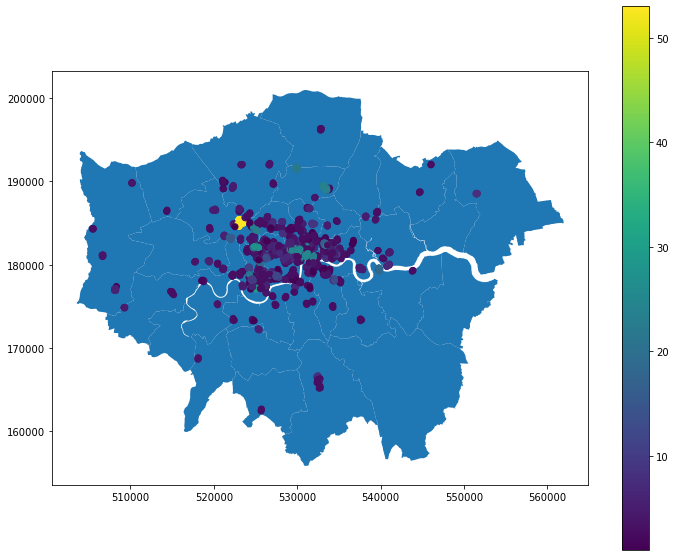

In [130]:
geo_ghost_hotels = gpd.GeoDataFrame(
    geo_ghost_hotels, geometry='geometry', crs='epsg:27700')


fig, ax = plt.subplots(1,1, figsize=(12,10))
boros.plot(ax=ax)
geo_ghost_hotels.plot(ax=ax, column='count', legend=True)

<AxesSubplot:ylabel='Frequency'>

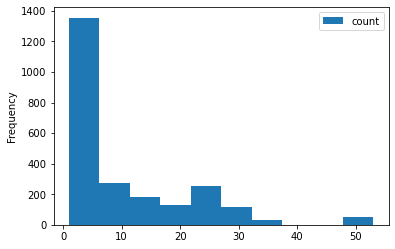

In [132]:
geo_ghost_hotels[['count']].plot.hist()

### Mapping percentage of listings in each MSOA that are ghost hotels

In [ ]:
#Get MSOAs and extract MSOAs that are in London
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')

#Dissolve borough boundaries by London boundary
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')

ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
del(msoas)